In [15]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from scipy.interpolate import griddata

In [16]:
phi = np.load("Phi_201snap.npy")
phi160 = phi[:,:,100]

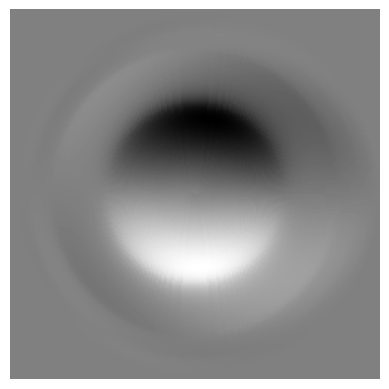

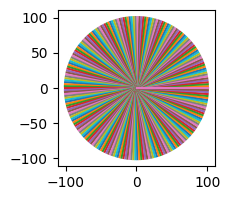

In [33]:
data = phi160

r = np.linspace(1, 101, 101)
theta = np.linspace(0, 2 * np.pi, 227)
r_grid, theta_grid = np.meshgrid(r, theta, indexing='ij')

# Convert polar coordinates to Cartesian coordinates
x = r_grid * np.cos(theta_grid)
y = r_grid * np.sin(theta_grid)

# Define the target grid for interpolation (203x203 pixels)
grid_x, grid_y = np.linspace(-101, 101, 203), np.linspace(-101, 101, 203)
grid_x, grid_y = np.meshgrid(grid_x, grid_y)

# Interpolate the data to the Cartesian grid
points = np.array([x.flatten(), y.flatten()]).T
values = data.flatten()
grid_z = griddata(points, values, (grid_x, grid_y), method='nearest')

# Plot the image
plt.imshow(grid_z, extent=(-101, 101, -101, 101), cmap='gray')
plt.axis("off")

# Save the image as 203x203 JPEG
dpi = 100
figsize = (203 / dpi, 203 / dpi)

# Create a figure with the specified size
fig = plt.figure(figsize=figsize, dpi=dpi)

# Add the plot to the figure
ax = fig.add_subplot(111)
ax.plot(x, y)

# Save the figure as a JPEG with the specified dimensions
output_path = 'output_image.jpeg'
fig.savefig(output_path, dpi=dpi, format='jpeg')